# MNIST Autoencoder Example

**Note**: This notebook is desinged to run on CPU (no GPU) runtime.

**[MAE-01]**

Install libraries.

In [1]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[MAE-02]**

Import modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state

plt.rcParams.update({'font.size': 12})

**[MAE-03]**

Download the MNIST dataset and store into NumPy arrays.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

**[MAE-04]**

Define a function to split the dataset into batches.

In [4]:
def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size)
    data_batched = np.array_split(data[:num_batches * batch_size], num_batches)
    if mod: # Last batch is smaller than batch_size
        data_batched.append(data[num_batches * batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched

**[MAE-05]**

Define an autoencoder model.

In [5]:
class AutoEncoderModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=784)(x)
        x = nn.sigmoid(x)
        return x

**[MAE-06]**

Create a training state object.

In [6]:
key, key1 = random.split(random.PRNGKey(0))
variables = AutoEncoderModel().init(key1, train_images[0:1])

state = train_state.TrainState.create(
    apply_fn=AutoEncoderModel().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001))

jax.tree_util.tree_map(lambda x: x.shape, state.params)

FrozenDict({
    Dense_0: {
        bias: (256,),
        kernel: (784, 256),
    },
    Dense_1: {
        bias: (128,),
        kernel: (256, 128),
    },
    Dense_2: {
        bias: (16,),
        kernel: (128, 16),
    },
    Dense_3: {
        bias: (128,),
        kernel: (16, 128),
    },
    Dense_4: {
        bias: (256,),
        kernel: (128, 256),
    },
    Dense_5: {
        bias: (784,),
        kernel: (256, 784),
    },
})

**[MAE-07]**

Define a loss function as the mean squar error.

In [7]:
@jax.jit
def loss_fn(params, state, inputs):
    predictions = state.apply_fn({'params': params}, inputs)
    loss = optax.l2_loss(predictions, inputs).mean()
    return loss

**[MAE-08]**

Define a function to apply a single training step that returns a new training state.

In [8]:
@jax.jit
def train_step(state, inputs):
    loss, grads = jax.value_and_grad(loss_fn)(state.params, state, inputs)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

**[MAE-09]**

Define a function to apply the training steps for one epoch.

In [9]:
def train_epoch(state, input_batched):
    loss_history = []
    for inputs in input_batched:
        new_state, loss = train_step(state, inputs)
        state = new_state
        loss_history.append(jax.device_get(loss).tolist())
    return state, np.mean(loss_history)

**[MAE-10]**

Define a function to show the training result.

In [10]:
def show_result(state):
    results = jax.device_get(
        state.apply_fn({'params': state.params}, jnp.asarray(test_images[:8])))
  
    fig = plt.figure(figsize=(16, 2.7))
    for i in range(8):
        subplot = fig.add_subplot(2, 10, i+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(test_images[i].reshape([28, 28]),
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

        subplot = fig.add_subplot(2, 10, i+11)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(results[i].reshape([28, 28]),
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

**[MAE-11]**

Train the model for a single epoch.

In [11]:
%%time
train_images_batched = create_batches(train_images, 128)
state, loss = train_epoch(state, train_images_batched)
print('Loss: {:.4f}'.format(loss))

Loss: 0.0225
CPU times: user 11.7 s, sys: 515 ms, total: 12.2 s
Wall time: 13.5 s


**[MAE-12]**

Show the training result.

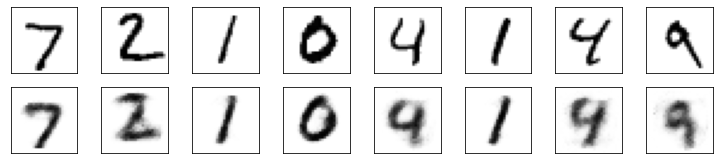

In [12]:
show_result(state)

**[MAE-13]**

Train the model for additional five epochs.

In [13]:
%%time
for _ in range(5):
    state, loss = train_epoch(state, train_images_batched)
    print('Loss: {:.4f}'.format(loss))

Loss: 0.0123
Loss: 0.0103
Loss: 0.0094
Loss: 0.0089
Loss: 0.0085
CPU times: user 38.6 s, sys: 2.48 s, total: 41.1 s
Wall time: 27.4 s


**[MAE-14]**

Show the training result.

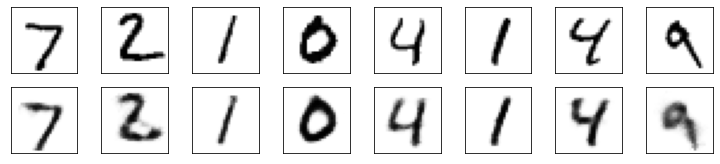

In [14]:
show_result(state)

**[MAE-15]**

Define a Javascript function to show a drawing canvas.

In [15]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e) {
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0, 0, 0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY*0.2);
            y = Math.floor(e.offsetX*0.2) + 1;
            for (var dy = 0; dy < 2; dy++) {
                for (var dx = 0; dx < 2; dx++) {
                    if ((x + dx < 28) && (y + dy < 28)) {
                        pixels[(y+dy)+(x+dx)*28] = 1;
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });
    
    function set_value() {
        var result = "";
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ",";
        google.colab.kernel.invokeFunction(
                          'notebook.set_image', [result], {});
    }
    
    function clear_value() {
        canvas.getContext("2d").fillStyle = "rgb(255, 255, 255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    }
</script>
"""

**[MAE-16]**

Show a drawing canvas.

In [16]:
from google.colab import output  
from IPython.display import HTML

def set_image(result):
    global image
    image = np.array([float(x) for x in result.split(',')[:-1]])

image = None
output.register_callback('notebook.set_image', set_image)

HTML(input_form + javascript)

**[MAE-17]**

Show the original image and the reconstructed image.

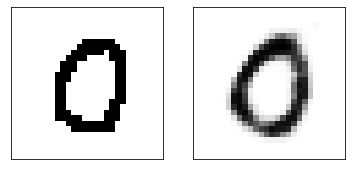

In [23]:
results = jax.device_get(
    state.apply_fn({'params':state.params}, jnp.asarray([image])))

fig = plt.figure(figsize=(6, 3))
subplot = fig.add_subplot(1, 2, 1)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(np.array(image).reshape([28, 28]), 
               vmin=0, vmax=1, cmap=plt.cm.gray_r)
subplot = fig.add_subplot(1, 2, 2)
subplot.set_xticks([])
subplot.set_yticks([])
_ = subplot.imshow(results[0].reshape([28, 28]),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)